<a href="https://colab.research.google.com/github/danielmarek22/Extraterrestial-Rock-Segmentation/blob/main/TrainingPipeline_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Basic necessary imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2

In [3]:
# Only run these cells when uploading files to collab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/eng_data/data.zip

In [8]:
# Prepare paths of input images and target segmentation masks
input_dir = "./render/"
target_dir = "./ground/" 
img_size = (320, 320)          #This is the biggest image I could get 
num_classes = 4
batch_size = 32
lower_color_treshold = 100

# Sorting image names in input folder
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".png")
])

#Sorting mask names in target folder
target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of input samples:", len(input_img_paths))
print("Number of target samples:", len(target_img_paths))

#Input and target images are now corresponding
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of input samples: 9766
Number of target samples: 9766
./render/render0001.png | ./ground/ground0001.png
./render/render0002.png | ./ground/ground0002.png
./render/render0003.png | ./ground/ground0003.png
./render/render0004.png | ./ground/ground0004.png
./render/render0005.png | ./ground/ground0005.png
./render/render0006.png | ./ground/ground0006.png
./render/render0007.png | ./ground/ground0007.png
./render/render0008.png | ./ground/ground0008.png
./render/render0009.png | ./ground/ground0009.png
./render/render0010.png | ./ground/ground0010.png


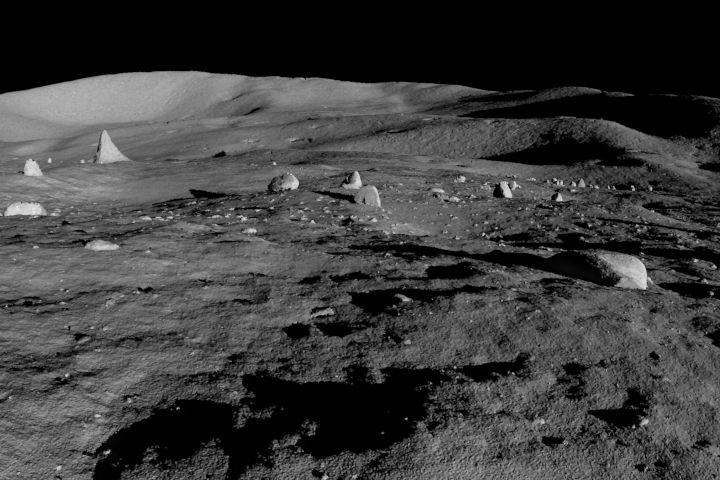

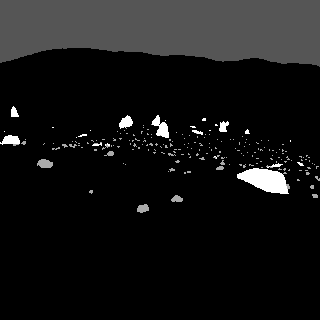

(320, 320, 1)
[0 1 2 3]


In [57]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# auxiliary utility functions

def extract_mask_from_ground(ground_img, lower_color_treshold):
  (R, G, B) = cv2.split(ground_img)
  R_ranged = np.clip(cv2.inRange(R, lower_color_treshold, 255), 0, 1) 
  G_ranged = np.clip(cv2.inRange(G, lower_color_treshold, 255), 0, 2) 
  B_ranged = np.clip(cv2.inRange(B, lower_color_treshold, 255), 0, 3)

  merged = cv2.merge([B_ranged, G_ranged, R_ranged])

  merged = np.expand_dims(merged, 3)
  merged = np.amax(merged, axis=2)
  return merged

def load_ground(path):
    img_ground = cv2.imread(path)
    img_ground_rgb = cv2.cvtColor(img_ground, cv2.COLOR_BGR2RGB)
    img_ground_rgb = cv2.resize(img_ground_rgb, img_size[::-1])
    return extract_mask_from_ground(img_ground_rgb, lower_color_treshold)

image_index = 13

# Display input image 
display(Image(filename=input_img_paths[image_index], width = 480, height = 480))

# Display auto-contrast version of corresponding target (per-pixel categories)


# Map pixel colors onto labels 

merged = load_ground(target_img_paths[image_index])

display(tf.keras.preprocessing.image.array_to_img(merged))

print(merged.shape)
print(np.unique(merged))


In [58]:
# Prepare Sequence class to load and vectorize batches of data

class LunarLandscape(keras.utils.all_utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        # Returns tuple (input, target) corresponding to batch idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 Dimensional input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
                
        # 1 Dimensional target mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            # load ground imahe
            y[j] = load_ground(path)
                
        return x, y


In [59]:
import random
# Split image paths into training and validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiane data Sequences for each split
train_gen = LunarLandscape(
            batch_size, img_size, train_input_img_paths, train_target_img_paths)

val_gen = LunarLandscape(
            batch_size, img_size, val_input_img_paths, val_target_img_paths)

[0 1 2 3]


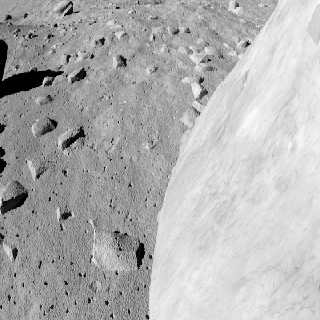

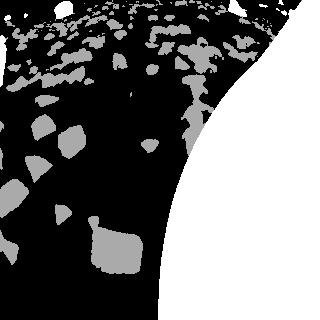

(320, 320, 3)
(320, 320, 1)


In [61]:
loader = LunarLandscape(
            batch_size, img_size, train_input_img_paths, train_target_img_paths)

print(np.unique(loader.__getitem__(1)[1][3]))
batch = loader.__getitem__(7)
display(tf.keras.preprocessing.image.array_to_img(batch[0][1]))
display(tf.keras.preprocessing.image.array_to_img(batch[1][1]))

print(batch[0][0].shape)
print(batch[1][0].shape)

In [ ]:
# Define model
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))
    #First half of the network: downsampling inputs
    
    #Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x #set aside residual
    
    #Blocks 1, 2, 3 are idencital apart from the feature depth
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        #Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation) 
        x = layers.add([x, residual]) #Add back residual
        previous_block_activation = x #Set aside next residual
        
    # Second half of the network: upsampling inputs
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)
        
        #Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) # Add back residaul
        previous_block_activation = x #set aside next residual
    
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

#Build the model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Compile model
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",
            #  metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("seg_model_480x480.h5", save_best_only=True)
]

epochs = 15
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


ResourceExhaustedError: ignored

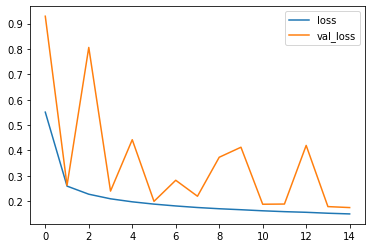

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.plot()

In [ ]:
#Generate predictions
val_gen = LunarLandscape(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


In [48]:
def get_mask_img(i):
    #Quick utilization to display a model's prediction

    mask = np.argmax(val_preds[i], axis=2)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    return img

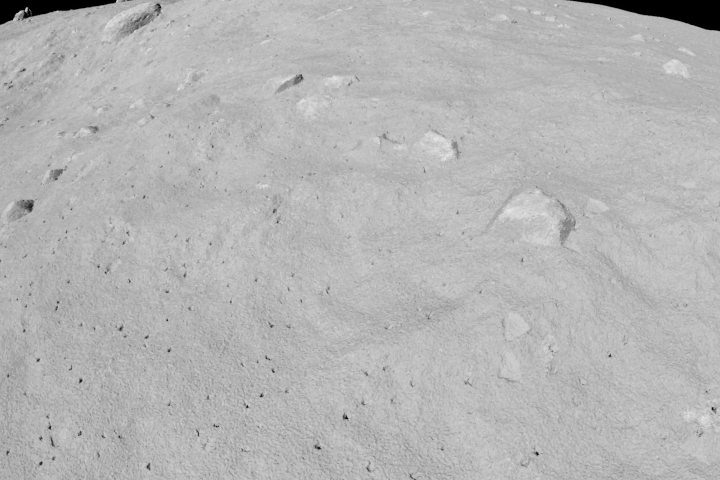

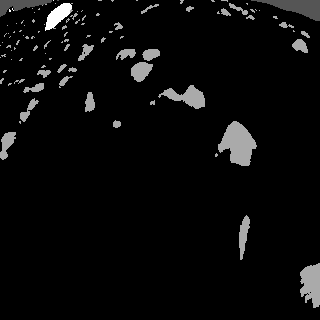

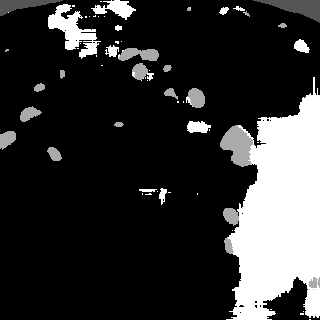

In [74]:
# Display results for validation image with index i
i = 4

# Display input image
display(Image(filename=val_input_img_paths[i]))

#Display ground-truth target mask
target = load_ground(val_target_img_paths[i])
display(tf.keras.preprocessing.image.array_to_img(target))

# Display mask predicted by model
pred_mask = get_mask_img(i)
display(pred_mask) # Model only sees inputs at 160x160

In [ ]:
model_loaded = keras.models.load_model('seg_model_320x320.h5')
model_loaded.summary()

In [70]:
val_gen = LunarLandscape(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model_loaded.predict(val_gen)

In [72]:
#Calculate mean IoU for predictions using loaded model

m = tf.keras.metrics.MeanIoU(num_classes=4)
result = []
for i, mask in enumerate(val_preds):
    mask = np.argmax(mask, axis=2)
    mask = np.expand_dims(mask, axis=-1)
    target = cv2.imread(val_target_img_paths[i])
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    target = cv2.resize(target, img_size[::-1])
    target = extract_mask_from_ground(target, lower_color_treshold)

    m.update_state(target, mask)
    result.append(m.result().numpy())

print(np.mean(result))


0.7273959


# Plan na dalsze prace:

- Ogarnąć zbiór danych, wyodrębnić więcej kamyków z ground truth oraz zapisać to czystszej postaci - done
- Utworzyć funkcje przerabiającą ground truth do takiej postacji jaką przyjmuje model - done
- Utworzyć funkcje nakładającą wygenerowaną mapę na rzeczywisty obraz
- Odpalić albo utworzyć metrykę IoU tak aby dawała wymierne rezultaty - kinda done
- dalej rozwijać model tzn:
    - utworzyć nowy model z wytrenowaną konwolucyjną bazą, może to być ten EfficentDet
    - spróbować całkowicie przetrenować już wcześniej utworzony model ale przerobiony pod segmentacje
  - ogarnąć sensowniejsze zapisywanie modeli
  - poszukać innych zbiorów danych na których można odpalić wytenowany model
  - zacząć zbierać literaturę ogólnie do pisania pracy
  
 ## Pytania na konsultacje:
 
 - Co zrobić dokładnie z tym zbiorem co jest teraz? Zostać przy clean images czy robić samemu (i tak zobaczę co można samemu zrobić)
 - jaka będzie najlepsza baza czy architektura do tego problemu?
 - ogólnie czy tak wykonany projekt jest dobrym podejściem czy raczej coś pozmieniać
 - co robić dalej? Tzn czy próbować to może odpalić na raspberry czy może znaleźć inną metrykę do ewaluacji wydajności?
 - zapytać też o ten EfficentDet, idziemy konkretnie w tym kierunku czy raczej to zostawiamy?
 - co z tradycyjnymi podejściami, też bieżemy pod uwagę np. algorytm knn?
 - jak będzie najlepsza wielkość obrazu wejściowego? zostać przy 320x320 albo 160x160 czy próbować coś większego?